# Step 3: Data Preprocessing and File Export

---

In this step, we will perform all the neccessary data processing as we discussed in the step 1 - EDA. This will optimize the model, and improve it's performance. The steps will include:

**Train Dataset:**
- Handle outliers for features that contain many outliers
- Apply data transformation to achieve normal distribution for skew features
- Apply normalization to put the features in the same scale
- Balance the dataset with feature sampling for target

**Test Dataset:**
- Apply data transformation to achieve normal distribution for skew features
- Apply normalization to put the features in the same scale

## 1. Importing the necessary libraries

In [1]:
# Imports library for data manipulation and visualisation
import sys
sys.path.append("../utilities")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from color import color
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# ignore all warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
df_train = pd.read_csv("../dataset/cleaned_train.csv")
df_test = pd.read_csv("../dataset/cleaned_test.csv")

## 2. Creating A Baseline Model For Evaluation

We will incorporate a baseline model to validate your data processing decisions as analyzed in EDA step. A baseline model can provides a simple benchmark against which we can compare the performance of our processing techniques. By establishing a baseline, we can assess whether your data processing steps are actually adding value and improving the performance of your models. Additionally, comparing against a baseline can help us identify potential issues or anomalies in thr data or processing pipeline.

For a baseline model, it will be more meaningful for us to choose a simple machine learning algorithm. By selecting a straightforward algorithm, such as a `Dummy Classifier` or `Logistic Regression` with minimal hyperparameter tuning, we can have a clear starting point for our comparison. This simplicity allows us to focus on the benefits gained from our data processing. We can also compare the logistic regression with the random dummy classifier to see the improvement of the logistic regression with the newly processed data.

For performance metrics to be simple, we will use **F1 score** to measure the model's performance, as F1 is a harmonic between precision (correctly identified diabetics) and recall (not missing true diabetics). This is crucial in diabetes prediction, where both accurately identifying those with diabetes and avoiding false positives (misdiagnosing healthy people) are important.

In [3]:
x = df_train.drop('Status', axis=1)  # Features
y = df_train[['Status']]  # Target 

In [4]:
x.head()

,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income,ExtraMedTest,ExtraAlcoholTest
0,0,0,24,1,0,0,1,0,1,0,0,2,0,0,0,0,8,5,60,0
1,0,0,28,0,0,0,1,1,1,0,0,1,0,0,0,0,2,8,0,-64
2,0,0,36,1,0,0,1,1,0,0,1,3,1,1,1,0,3,1,-46,0
3,0,1,35,0,0,0,1,1,1,0,0,3,0,0,0,0,8,8,-83,-188
4,0,1,27,0,0,0,1,0,1,0,0,3,0,0,0,0,9,4,-58,0


In [5]:
y.head()

,Status
0,0
1,0
2,0
3,0
4,0


In [6]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train the logistic regression model
logReg_clf = LogisticRegression(penalty=None, class_weight="balanced", max_iter=1_000, random_state=99)
logReg_clf.fit(x_train, y_train)

# Predict on the test set
y_pred_logReg = logReg_clf.predict(x_test)

logReg_clf_report = classification_report(y_test, y_pred_logReg)
print(color.RED + color.BOLD + "Logistic Regression Baseline Classification Report:\n" + color.END)
print(logReg_clf_report)

# Train a Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=99)
dummy_clf.fit(x_train, y_train)

# Predict on the test set
y_pred_dummy = dummy_clf.predict(x_test)

dummy_clf_report = classification_report(y_test, y_pred_dummy)
print(color.RED + color.BOLD + "Dummy Classifier Classification Report:\n" + color.END)
print(dummy_clf_report)


Logistic Regression Baseline Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     33388
           1       0.61      0.87      0.72      7078

    accuracy                           0.88     40466
   macro avg       0.79      0.88      0.82     40466
weighted avg       0.91      0.88      0.89     40466

Dummy Classifier Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     33388
           1       0.18      0.18      0.18      7078

    accuracy                           0.71     40466
   macro avg       0.50      0.50      0.50     40466
weighted avg       0.71      0.71      0.71     40466



Both model is currently better at predicting for negative (0) values

## 3. Data Processing

### 3.1 Data Overview Before Processing

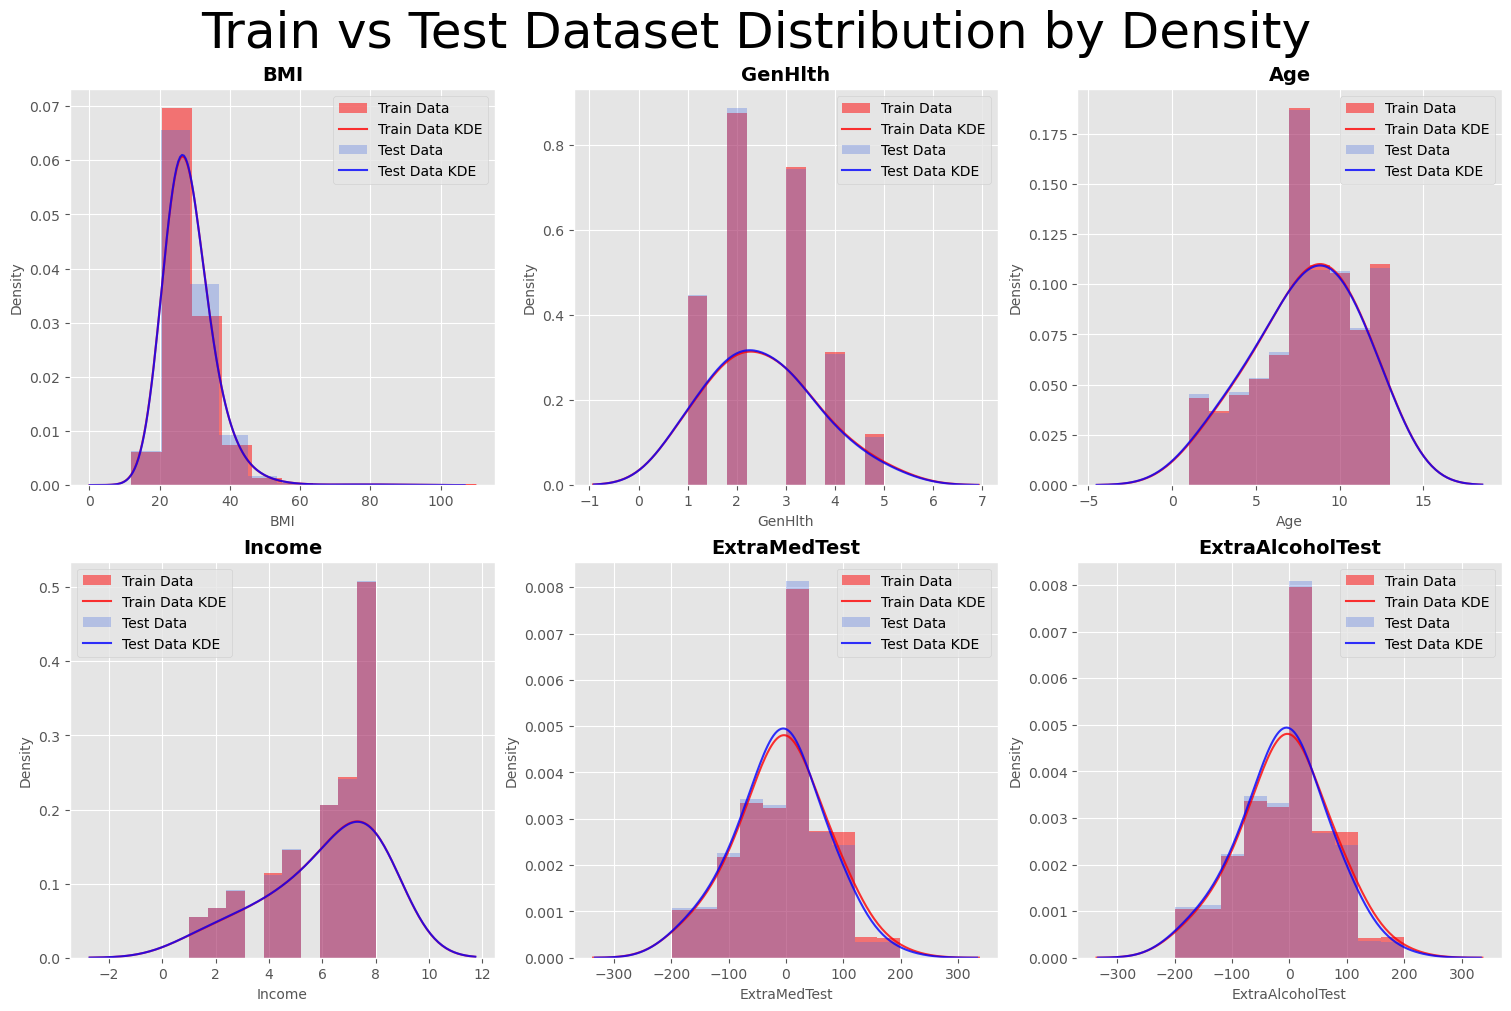

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), constrained_layout=True)
axes = axes.ravel()
fig.suptitle("Train vs Test Dataset Distribution by Density", fontsize=36)

for i, col in enumerate(df_train[['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']].columns):
    axes[i].hist(
        df_train[col], color="r", density=True, alpha=0.5, label="Train Data"
    )
    sns.kdeplot(df_train[col], ax=axes[i], color="red", alpha=0.8, label="Train Data KDE", bw_method=0.6)

    axes[i].hist(
        df_test[col], color="royalblue", density=True, alpha=0.3, label="Test Data"
    )
    sns.kdeplot(df_test[col], ax=axes[i], color="blue", alpha=0.8, label="Test Data KDE", bw_method=0.6)

    axes[i].set_ylabel("Density", fontsize=10)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].tick_params(axis="both", which="major", labelsize=10)
    axes[i].set_title(col, fontsize=14, fontweight="bold")
    axes[i].legend()

plt.show()

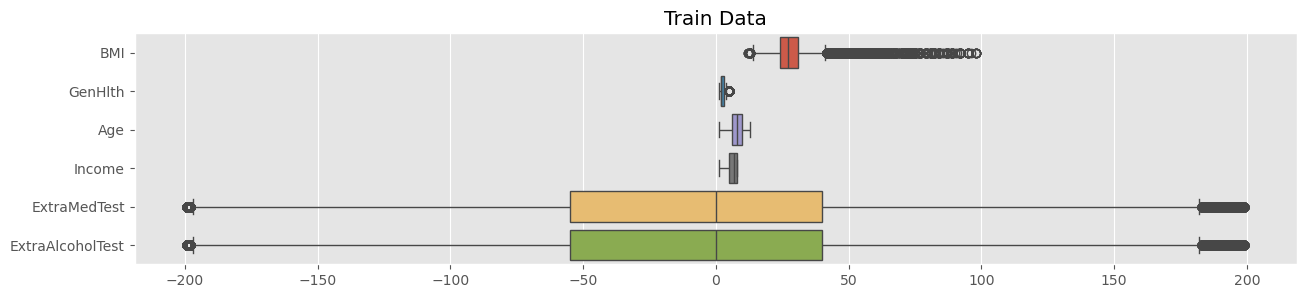

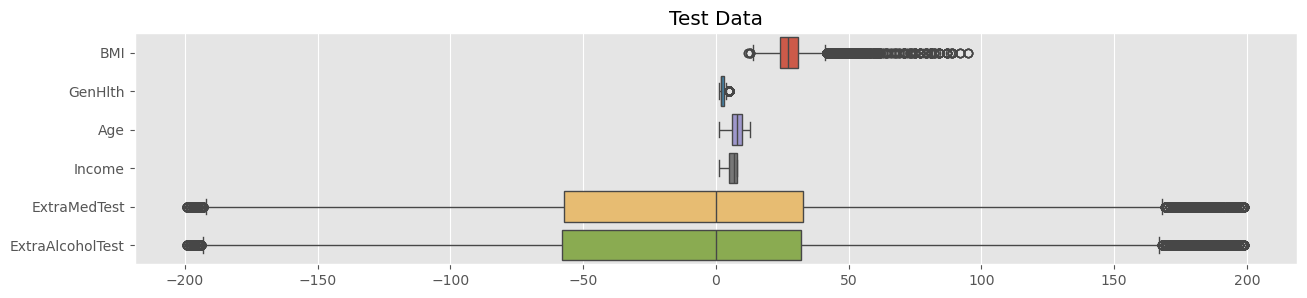

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))

sns.boxplot(data=df_train[['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']], orient="h", ax=axes)

axes.set_title("Train Data")

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))

sns.boxplot(data=df_test[['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']], orient="h", ax=axes)

axes.set_title("Test Data")

plt.show()

### 3.2 Handling Outliers

For the numerical features that contains outliers, we will use a K-Nearest Neighbor (KNN) imputers to imputes the outliers based on the IQR. We will first convert all outlier to null values, imputes them with KNN, then cap all extreme values to fall within the IQR +- whisker width.

In [9]:
cols = ['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']

Q1 = df_train[cols].quantile(0.25)
Q3 = df_train[cols].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in cols:
    # Replace outliers with null value
    df_train[col] = df_train[col].where((df_train[col] >= lower_bound[col]) & (df_train[col] <= upper_bound[col]), np.nan)
    
    # Use KNN imputer to assign new value
    df_train[[col]] = KNNImputer(n_neighbors=30).fit_transform(df_train[[col]])
    
    # Cap outliers in to range
    df_train[col] = np.where(df_train[col] < lower_bound[col], lower_bound[col], df_train[col]) # Value less than lower bound become lower bound
    df_train[col] = np.where(df_train[col] > upper_bound[col], upper_bound[col], df_train[col])

### 3.3 Data Transformation

We have a mix of positively skewed (2), negatively skewed (2), and normally distributed (2) data, we can use Box-Cox transformation method because it can can handle both positive and negative skewness effectively.

In [10]:
cols = ['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']

for col in cols:
    # Transformation
    if(col != 'ExtraMedTest' and col != 'ExtraAlcoholTest'):
        df_train[col], _ = boxcox(df_train[col] + 0.001)  # Add 1 to handle zero values
        df_test[col], _ = boxcox(df_test[col] + 0.001)  # Add 1 to handle zero values

### 3.4 Balance The Dataset

As discussed in part 1 - EDA, I oversampled the minority class to match 40% of the majority class, and then undersampled the majority class by 66.7%, so we have a distribution of **40% (minority) and 60% (majority)**, which is the minimum acceptable rate for a dataset to be balanced. By this we can prevent losing as much information from the majority class as possible.

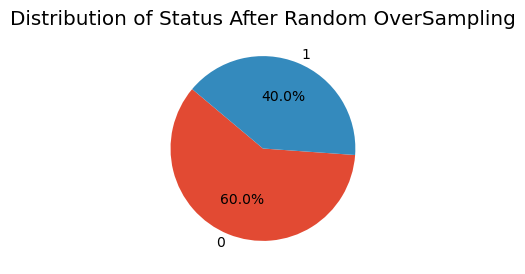

Rows reduced: 69054


In [11]:
row_before = df_train.shape[0]
# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42, sampling_strategy=0.4)
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.667)

# Perform random oversampling
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

# Reconstruct DataFrame with resampled data
sampled_df = pd.DataFrame(x_train_resampled, columns=x_train.columns)
sampled_df['Status'] = y_train_resampled

# Under Sampler
x_train = sampled_df.drop('Status', axis=1)  
y_train = sampled_df['Status']

x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

df_train = pd.DataFrame(x_train_resampled, columns=x_train.columns)
df_train['Status'] = y_train_resampled

counts = df_train['Status'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Status After Random OverSampling')
plt.show()

df_train.shape

print(color.RED + color.BOLD + "Rows reduced: " + color.END + str((row_before - df_train.shape[0])))

### 3.5 Data Scaling/ Normalization

We also have data that have vastly different scale, and not neccesarily centered around 0, so we can apply a Standard scaler to scales features to have a mean of 0 and a standard deviation of 1 and still preserve the relationships between the original values.

In [12]:
scaler = StandardScaler()
cols = ['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']

for col in cols:
    scaler.fit(df_train[[col]])  # Fit scaler only on training data
    df_train[[col]] = scaler.fit_transform(df_train[[col]])
    df_test[[col]] = scaler.fit_transform(df_test[[col]])

### 3.6 Result After Processing

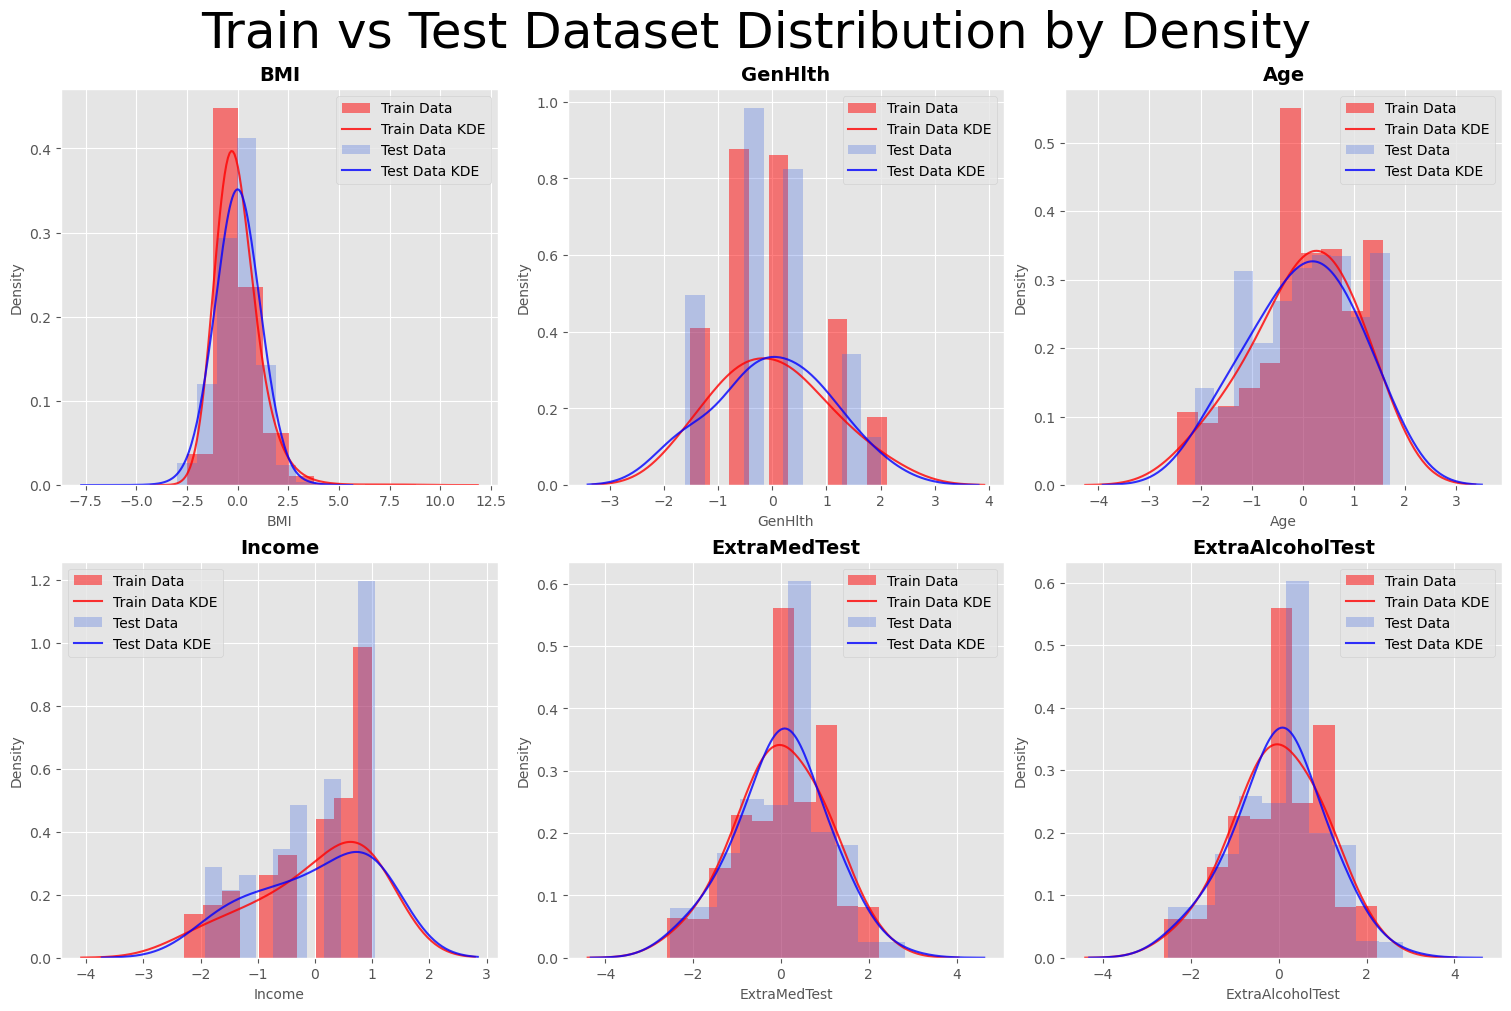

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), constrained_layout=True)
axes = axes.ravel()
fig.suptitle("Train vs Test Dataset Distribution by Density", fontsize=36)

for i, col in enumerate(df_train[['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']].columns):
    axes[i].hist(
        df_train[col], color="r", density=True, alpha=0.5, label="Train Data"
    )
    sns.kdeplot(df_train[col], ax=axes[i], color="red", alpha=0.8, label="Train Data KDE", bw_method=0.6)

    axes[i].hist(
        df_test[col], color="royalblue", density=True, alpha=0.3, label="Test Data"
    )
    sns.kdeplot(df_test[col], ax=axes[i], color="blue", alpha=0.8, label="Test Data KDE", bw_method=0.6)

    axes[i].set_ylabel("Density", fontsize=10)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].tick_params(axis="both", which="major", labelsize=10)
    axes[i].set_title(col, fontsize=14, fontweight="bold")
    axes[i].legend()

plt.show()

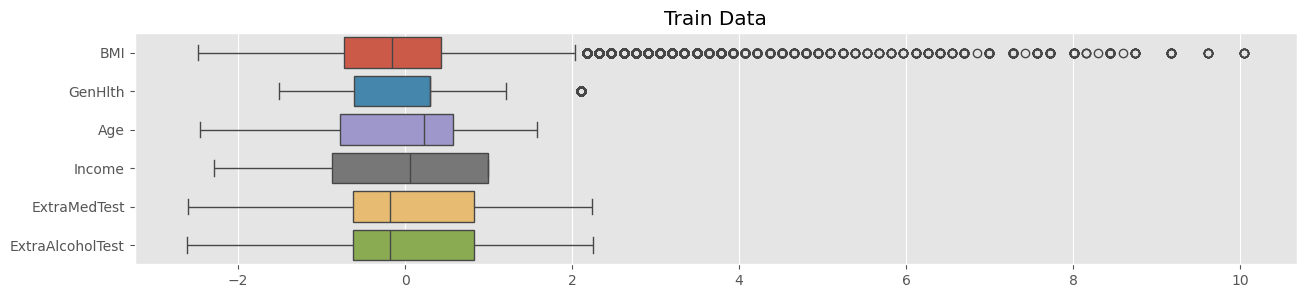

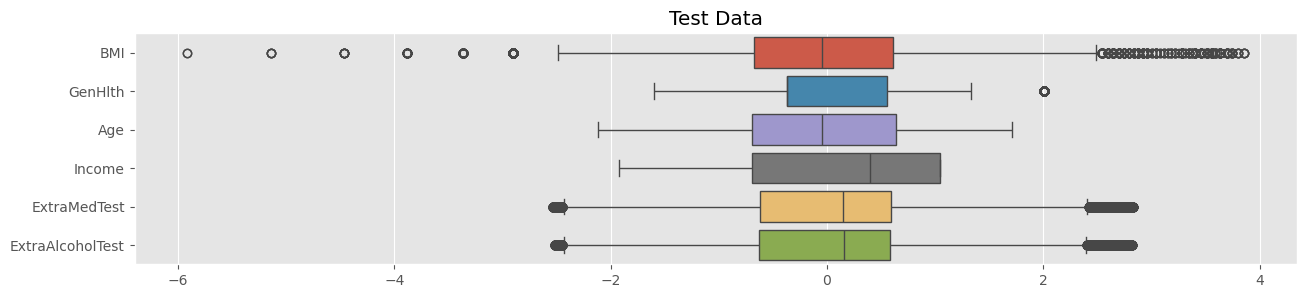

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))

sns.boxplot(data=df_train[['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']], orient="h", ax=axes)

axes.set_title("Train Data")

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))

sns.boxplot(data=df_test[['BMI', 'GenHlth', 'Age', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest']], orient="h", ax=axes)

axes.set_title("Test Data")

plt.show()


## 4. New Performance Measurement

In [15]:
print(color.RED + color.BOLD + "Baseline Logistic Regression Baseline Classification Report:\n" + color.END)
print(logReg_clf_report)

print(color.RED + color.BOLD + "Baseline Dummy Classifier Classification Report:\n" + color.END)
print(dummy_clf_report)


x = df_train.drop('Status', axis=1)  # Features
y = df_train[['Status']]  # Target 

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train the logistic regression model
logReg_clf = LogisticRegression(penalty=None, class_weight="balanced", max_iter=1_000, random_state=99)
logReg_clf.fit(x_train, y_train)

# Predict on the test set
y_pred_logReg = logReg_clf.predict(x_test)

logReg_clf_report_new = classification_report(y_test, y_pred_logReg)
print(color.BLUE + color.BOLD + "New Logistic Regression Baseline Classification Report:\n" + color.END)
print(logReg_clf_report_new)

# Train a Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=99)
dummy_clf.fit(x_train, y_train)

# Predict on the test set
y_pred_dummy = dummy_clf.predict(x_test)

dummy_clf_report_new = classification_report(y_test, y_pred_dummy)
print(color.BLUE + color.BOLD + "Baseline Dummy Classifier Classification Report:\n" + color.END)
print(dummy_clf_report_new)


Baseline Logistic Regression Baseline Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     33388
           1       0.61      0.87      0.72      7078

    accuracy                           0.88     40466
   macro avg       0.79      0.88      0.82     40466
weighted avg       0.91      0.88      0.89     40466

Baseline Dummy Classifier Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     33388
           1       0.18      0.18      0.18      7078

    accuracy                           0.71     40466
   macro avg       0.50      0.50      0.50     40466
weighted avg       0.71      0.71      0.71     40466

New Logistic Regression Baseline Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     15892
           1       0.83      0.88      0.85     10763

    accuracy 

According to the result:
- The overall f1-score result of the New Logistic Regression is better than the Baseline
- The f1-score for detecting `1 (positive)` of the New Logistic Regression is better than the Baseline. Suggest that we solve the imbalanced bias problem.
- The new logistic regression model performs significantly better than the new dummy classifier, compare to the 2 baseline model. Suggesting that with the processed data, the model has learned meaningful patterns from the data and is making more accurate predictions. This improvement indicates that the model is capturing the underlying relationships in the data better than random chance.

## 5. Saving New Processed Datasets

In [16]:
df_train.to_csv("../dataset/processed_train.csv", index=False)
df_test.to_csv("../dataset/processed_test.csv", index=False)